In [1]:
# Configuración de SparkSession
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, FloatType, StringType, IntegerType, DateType
from pyspark.sql.functions import mean, round, std, max, min
import matplotlib.pyplot as plt
import pandas as pd


spark = SparkSession.builder.master("local").appName("Análisis Exploratorio").getOrCreate()
spark

In [2]:
# Importo el fichero localizado en la misma ruta del projecto
data = spark.read.options(inferShema='True', delimiter= ',', header=True).csv('CSV_stocks_2021.csv')
data.printSchema()

root
 |-- ticker: string (nullable = true)
 |-- open: string (nullable = true)
 |-- high: string (nullable = true)
 |-- low: string (nullable = true)
 |-- close: string (nullable = true)
 |-- volume: string (nullable = true)
 |-- dividends: string (nullable = true)
 |-- stock splits: string (nullable = true)
 |-- date: string (nullable = true)
 |-- ccy: string (nullable = true)



Al importar el fichero e indicarle en la configuración que realizara la inferencia de datos de forma automática **inferSchema=True**, observo como las columnas han sido inferidas a datos de tipo String, cuando realmente nos encontramos con diversos tipos de datos. Por este motivo, volveré a cargar los datos infiriendo manualmente en el tipo de dato para cada columna.

In [3]:
# Defino el Schema manualmente
custom_schema = StructType([
    StructField("ticker", StringType(), True),
    StructField("open", FloatType(), True),
    StructField("high", FloatType(), True),
    StructField("low", FloatType(), True),
    StructField("close", FloatType(), True),
    StructField("volume", IntegerType(), True),
    StructField("dividends", FloatType(), True),
    StructField("stock splits", IntegerType(), True),
    StructField("date", DateType(), True),
    StructField("ccy", StringType(), True)])

data = spark.read.schema(custom_schema).option("delimiter", ",").option("header", "true").csv("CSV_stocks_2021.csv")
data.printSchema()
    

root
 |-- ticker: string (nullable = true)
 |-- open: float (nullable = true)
 |-- high: float (nullable = true)
 |-- low: float (nullable = true)
 |-- close: float (nullable = true)
 |-- volume: integer (nullable = true)
 |-- dividends: float (nullable = true)
 |-- stock splits: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- ccy: string (nullable = true)



# 🎓 Estadística Descriptiva

Realizamos un primer análisis orientado a proporcionar, mediante una serie de resultados numéricos y gráficos, una primera aproximación al conjunto de datos con el que vamos a trabajar para identificar algunas métricas relevantes que nos ayudaran a realizar los análisis posteriroes.

In [4]:
data.show(10)

+------+---------+---------+---------+---------+-------+---------+------------+----------+---+
|ticker|     open|     high|      low|    close| volume|dividends|stock splits|      date|ccy|
+------+---------+---------+---------+---------+-------+---------+------------+----------+---+
|   HON|207.45502|209.42142|206.14735|209.12645|1406400|      0.0|           0|2020-12-31|USD|
|   HON| 209.2641|209.43124|202.89297|204.45625|2328900|      0.0|           0|2021-01-04|USD|
|   HON|203.50256|206.65863|203.50256| 204.9577|2172100|      0.0|           0|2021-01-05|USD|
|   HON|205.93106|210.38495|205.71475|208.69385|2747900|      0.0|           0|2021-01-06|USD|
|   HON|209.31328|210.41446|207.25839|209.03798|2057300|      0.0|           0|2021-01-07|USD|
|   HON|209.22478|209.82452|204.18097|206.50131|3278900|      0.0|           0|2021-01-08|USD|
|   HON|204.61356|206.09819|204.33827|204.85936|2938900|      0.0|           0|2021-01-11|USD|
|   HON|204.36778|205.96056|201.81146|205.37065|24

In [5]:
# Compruebo si la columna ticker existen diferentes categorias de datos, para es caso afirmativo, agruparlos más adelante
categorias_ticker = data.select('ticker').distinct()
categorias_ticker.show()

+-------+
| ticker|
+-------+
|     EA|
|   AAPL|
| REP.MC|
|    DIS|
|   TSLA|
|     VZ|
|    NRG|
|   GOOG|
|     FB|
|   GOLD|
| ITX.MC|
|    WMT|
|     BA|
|   SNOW|
|   ENPH|
|CLNX.MC|
| IAG.MC|
|   MSFT|
|    HON|
| SAN.MC|
+-------+



#### 📈 Análisis de la media por Tipo de Acción en función de sus **valores en la Apertura (open)**, **Precio más alto (high)**, **Precio más bajo (low)**, **Precio en el cierre (close)** y **Acciones Vendidas Durante el Día (volume)**

Esta tabla proporciona un conjunto de medias diarias para varias acciones, destacando métricas clave como el **precio de apertura, el precio más alto, el precio más bajo, el precio de cierre y el volumen de operaciones**. Este análisis descriptivo se centra en interpretar las tendencias generales y comparativas de las acciones seleccionadas. A continuación analizamos algunas de las acciones mostradas en esta tabla.

Comenzando con **Electronic Arts Inc. (EA)**, la acción presenta una estabilidad general con medias de precios cercanas entre sí. La volatilidad en los precios más altos y más bajos es relativamente baja, indicando una fluctuación moderada durante el período analizado. El volumen medio negociado sugiere una actividad comercial constante, pero no excepcionalmente alta.

**Apple Inc. (AAPL)**, una de las acciones más destacadas en el mercado, muestra medias de precios consistentes, con un precio de apertura medio de 140.31 dólares y un cierre medio de $140.43. Estos valores indican una estabilidad en el rendimiento diario, respaldada por un volumen medio significativamente alto de 90,656,116.27. Esto refleja la gran liquidez y el interés constante de los inversores en esta acción.

La empresa española **Repsol S.A. (REP.MC)** exhibe precios más bajos en comparación con las acciones tecnológicas, con un precio de apertura medio de $10.06. El volumen medio negociado es relativamente modesto en comparación con las acciones más grandes, lo que puede reflejar un interés más localizado en la empresa.

**The Walt Disney Company (DIS)** muestra medias de precios consistentes, con una ligera variabilidad en comparación con otras acciones tecnológicas. El volumen medio es significativo, indicando un interés constante en las acciones de Disney, posiblemente influenciado por eventos de entretenimiento clave, como el lanzamiento de nuevas películas de animación o su canal de cine en streaming.

**Tesla, Inc. (TSLA)** destaca por su alta volatilidad en los precios, con un rango extenso entre el precio más alto y más bajo. El volumen medio negociado es sustancialmente alto, indicando un interés masivo y una participación activa de los inversores en esta acción de alto perfil.

**Verizon Communications Inc. (VZ)** exhibe medias de precios y volúmenes de operaciones relativamente estables. Aunque no tiene la misma volatilidad que algunas acciones tecnológicas, su atractivo radica en la estabilidad y la confiabilidad.

**Google** muestra medias de precios considerablemente altas, **siendo una de las acciones tecnológicas líderes**. Con un precio de apertura medio de 2,503.55 dólares, **GOOG refleja una estabilidad y fortaleza en su rendimiento diario**. La diferencia entre los precios más altos y más bajos es moderada, indicando una volatilidad controlada. El precio de cierre medio es de aproximadamente $2,506.08. El volumen medio negociado es significativo, señalando un interés constante de los inversores en una de las principales empresas tecnológicas del mundo.

**Facebook** presenta medias de precios y volúmenes de operaciones considerables. Con un precio de apertura medio de 320.82 dólares, **FB** refleja una estabilidad en su rendimiento diario. La diferencia entre los precios más altos y más bajos sugiere una volatilidad moderada. El precio de cierre medio es de aproximadamente $320.92. El volumen medio negociado es notablemente alto, indicando un interés activo por parte de los inversores en una de las principales empresas de tecnología y redes sociales.

**Banco Santander(SAN.MC)**, cotizada en la bolsa española, refleja medias de precios y volúmenes de operaciones estables, indicando la solidez y la confianza en el sector bancario.

**Microsoft MSFT** muestra medias de precios y volúmenes de operaciones altos, indicando la estabilidad y el atractivo de las grandes empresas tecnológicas.

In [6]:
# Calcúlo la media para las columnas open, high, low, close y volume en función del tipo de catgoria
# Utilizo la función round para mostrar el resultado con 2 decimales

ticker_mean = data.groupBy('ticker').agg(
    round(mean('open'), 2).alias('Open Media'),
    round(mean('high'), 2).alias('high Media'),
    round(mean('low'), 2).alias('low Media'),
    round(mean('close'),2 ).alias('close Media'),
    round(mean('volume'), 2).alias('volume Media')
)

ticker_mean.show()

+-------+----------+----------+---------+-----------+-------------+
| ticker|Open Media|high Media|low Media|close Media| volume Media|
+-------+----------+----------+---------+-----------+-------------+
|     EA|    138.58|    140.13|   136.95|     138.47|   2546703.57|
|   AAPL|    140.31|    141.79|   138.92|     140.43|9.065611627E7|
| REP.MC|     10.06|      10.2|     9.93|      10.07|   8459940.86|
|    DIS|     176.2|    177.83|   174.24|     175.99|1.024983373E7|
|   TSLA|    778.36|    794.29|   761.27|      778.6|2.753071786E7|
|     VZ|     54.36|      54.7|    54.04|      54.34|1.835010317E7|
|    NRG|     38.86|      39.4|    38.34|      38.88|   2800224.21|
|   GOOG|   2503.55|    2526.7|  2482.72|    2506.08|   1264756.75|
|     FB|    320.82|    324.74|   317.14|     320.92|1.886636349E7|
|   GOLD|     20.34|     20.55|    20.07|      20.31|1.745027143E7|
| ITX.MC|     28.98|     29.28|    28.67|      28.99|   4585796.11|
|    WMT|    140.51|    141.55|   139.59|      1

In [7]:
# Calculo el valor medio de la columna Open y Columna Low
total_mean = data.agg(
    round(mean('open'),2 ).alias ('Open Media Total'),
    round(mean('low'),2 ).alias ('low Media Total')
)
total_mean.show()

+----------------+---------------+
|Open Media Total|low Media Total|
+----------------+---------------+
|          278.06|         274.65|
+----------------+---------------+



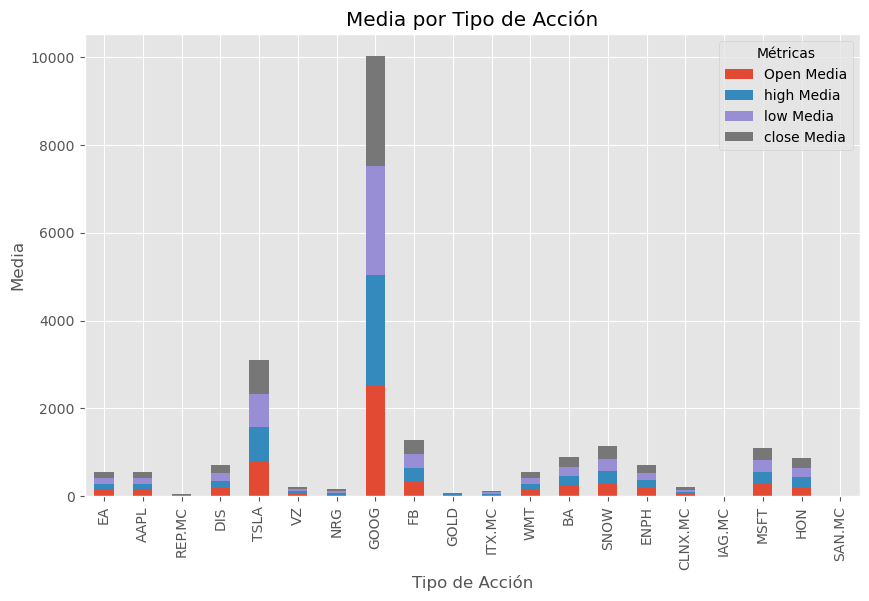

In [8]:
# Convierto el DataFrame de PySpark a DataFrame de Pandas para generar un gráfico
# Omito la columna volume ya que sus valores tan elevandos no permiten realizar una comparación con el resto de columnas
chart_mean = ticker_mean.toPandas()

# Tipo del Gráfico
plt.style.use('ggplot')

# Defino las columnas
columns = ['Open Media', 'high Media', 'low Media', 'close Media']

# Configuración del gráfico
chart_mean.set_index('ticker')[columns].plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Tipo de Acción')
plt.ylabel('Media')
plt.title('Media por Tipo de Acción')
plt.legend(title='Métricas')
plt.show()

#### 📈 Análisis de la Desviación Estándar en función del Precio de Apertura

La desviación estándar mide la dispersión de los valores con respecto a la media, lo que se traduce en la variabilidad de los precios. En este conjunto de datos, se presenta la desviación estándar para cada acción en su apertura.

**"TSLA"** destaca con una desviación estándar significativamente alta de 159.6, indicando una mayor variabilidad en los precios de apertura. Esto sugiere que las acciones de **Tesla** experimentaron fluctuaciones notables durante el período de tiempo considerado. Por otro lado, acciones como **"AAPL" y "MSFT"** muestran desviaciones estándar más moderadas de alrededor de 14.5 y 37.4, respectivamente, lo que podría indicar una menor volatilidad en comparación con **"TSLA"**.

La desviación estándar para **"GOOG"** es notable en términos absolutos, con valores superiores a los puntos 300. Estos resultados sugieren que **Google** expewrimentó variaciones sustanciales en sus precios de apertura durante el período analizado. Por otro lado, aciones como **"SAN.MC"** muestran una desviación estándar muy baja, alrededor de 0.24, indicando una relativa estabilidad en los precios de apertura de **Santander** durante ese periodo de tiempo.

In [9]:
# Calcúlo la Desviación Estandar para las columnas open, high, low, close y volume en función del tipo de catgoria
# Utilizo la función round para mostrar el resultado con 2 decimales

ticker_stddev = data.groupBy('ticker').agg(
    round(std('open'), 2).alias('Open Stddev'),
    round(std('high'), 2).alias('high Stddev'),
    round(std('low'), 2).alias('low Stddev'),
    round(std('close'),2 ).alias('close Stddev'),
    round(std('volume'), 2).alias('volume Stddev')
)

ticker_stddev.show()

+-------+-----------+-----------+----------+------------+-------------+
| ticker|Open Stddev|high Stddev|low Stddev|close Stddev|volume Stddev|
+-------+-----------+-----------+----------+------------+-------------+
|     EA|       5.74|       5.73|      5.77|        5.84|   1042820.18|
|   AAPL|      14.49|      14.76|     14.44|       14.67|2.915670875E7|
| REP.MC|       0.88|       0.87|      0.87|        0.87|   7270038.03|
|    DIS|      11.84|      11.94|     11.58|       11.69|    5884391.5|
|   TSLA|      159.6|     164.73|    154.44|      160.33|1.216738802E7|
|     VZ|        1.7|       1.68|      1.72|        1.71|   6527903.99|
|    NRG|       3.14|       3.14|      3.15|        3.15|   1740362.86|
|   GOOG|     371.83|     370.37|    369.18|       369.6|     494656.2|
|     FB|       34.8|      34.58|     34.87|       34.97|   8315984.18|
|   GOLD|       1.68|       1.68|      1.65|        1.67|   6100472.39|
| ITX.MC|       2.05|       2.06|      2.02|        2.05|   5685

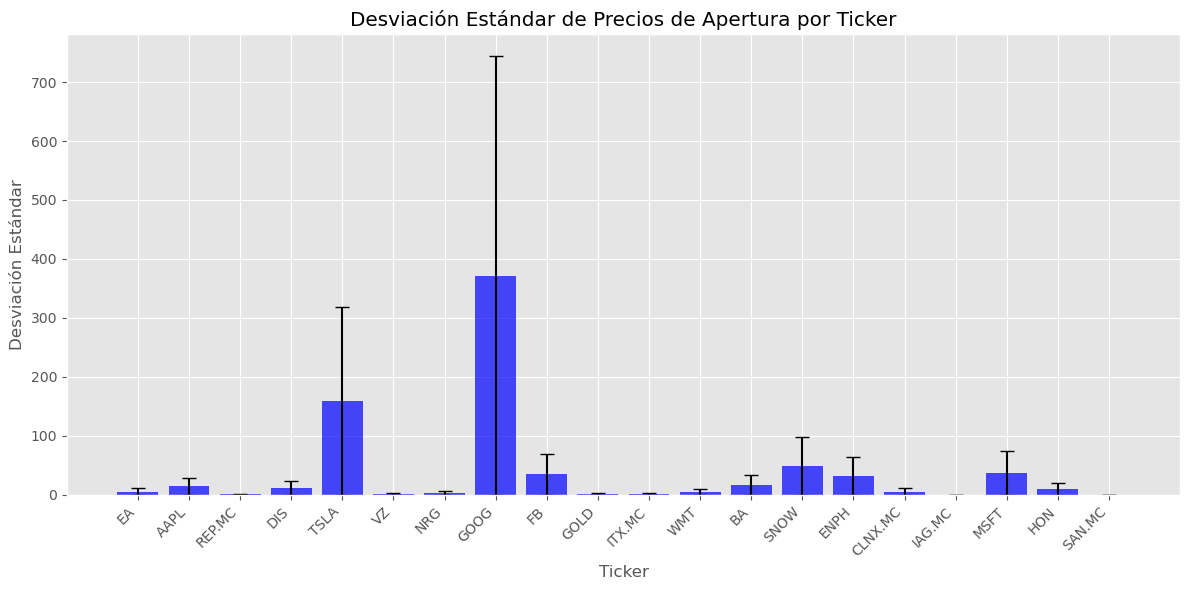

In [10]:
# Convierto el RDD a una lista de diccionarios
ticker_stddev_list = ticker_stddev.collect()

# Creo listas de tickers, desviaciones estándar y errores
tickers = [row['ticker'] for row in ticker_stddev_list]
open_stddev = [row['Open Stddev'] for row in ticker_stddev_list]
errors = [row['Open Stddev'] for row in ticker_stddev_list]  

# Creo el gráfico de barras de error
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(tickers, open_stddev, yerr=errors, capsize=5, color='blue', alpha=0.7)

# Añado las etiquetas y el título
ax.set_ylabel('Desviación Estándar')
ax.set_xlabel('Ticker')
ax.set_title('Desviación Estándar de Precios de Apertura por Ticker')


plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### 📈 Análisis de los valores Máximos y Mínimos

Al observar los datos, se puede destacar que existen diferencias significativas en los rangos de precios entre las acciones. Por ejemplo, para la acción de **TSLA**, la diferencia entre el precio máximo y mínimo de apertura es **notablemente amplia**, con un máximo de 1234.41 y un mínimo de 552.55. Esto indica una **volatilidad significativa en el precio de apertura**.

Asimismo, se observa una variación sustancial en los volúmenes máximos y mínimos de operaciones. Para acciones como **AAPL y MSFT**, el volumen máximo supera los 195 millones, mientras que para otras como **ITX.MC y SAN.MC**, los volúmenes máximos alcanzan cifras considerables, como 41117310 y 367211467 respectivamente.

En términos de análisis comparativo, se pueden identificar tendencias y patrones únicos para cada acción. Por ejemplo, **GOOG** muestra una diferencia menos pronunciada entre los precios máximos y mínimos, lo que **sugiere una mayor estabilidad en los precios de apertura, máximos, mínimos, cierre y volumen**.

In [11]:
# Calcúlo los valores máximo y mínimos para las columnas open, high, low, close y volume en función del tipo de catgoria
# Utilizo la función round para mostrar el resultado con 2 decimales

ticker_maxmin = data.groupBy('ticker').agg(
    round(max('open'), 2).alias('Open max'),
    round(min('open'), 2).alias('Open min'),
    round(max('high'), 2).alias('high max'),
    round(min('high'), 2).alias('high min'),
    round(max('low'), 2).alias('low max'),
    round(min('low'), 2).alias('low min'),
    round(max('close'),2 ).alias('close max'),
     round(min('close'),2 ).alias('close min'),
    round(max('volume'), 2).alias('volume max'),
    round(min('volume'), 2).alias('volume min')
)

ticker_maxmin.show()

+-------+--------+--------+--------+--------+-------+-------+---------+---------+----------+----------+
| ticker|Open max|Open min|high max|high min|low max|low min|close max|close min|volume max|volume min|
+-------+--------+--------+--------+--------+-------+-------+---------+---------+----------+----------+
|     EA|  148.54|  120.49|  149.56|  123.59| 145.78| 119.92|   148.23|   120.07|   8344300|    912300|
|   AAPL|  181.12|  118.48|  182.13|  119.84| 178.53| 115.67|   180.33|   115.82| 195432700|  41000000|
| REP.MC|   11.69|    7.87|   11.78|    7.97|  11.51|   7.74|    11.69|     7.75|  61950437|   2138799|
|    DIS|  200.19|  142.84|  203.02|  147.28|  195.4| 142.04|   201.91|   142.15|  62366500|   4131000|
|   TSLA| 1234.41|  552.55| 1243.49|  566.21| 1217.0| 539.49|  1229.91|    563.0|  89396500|   9800600|
|     VZ|   58.43|   49.83|   58.49|   50.33|  57.68|  49.69|    58.17|    49.77|  54501100|   8378900|
|    NRG|   45.41|   31.78|   45.73|   32.19|  44.88|  31.44|   

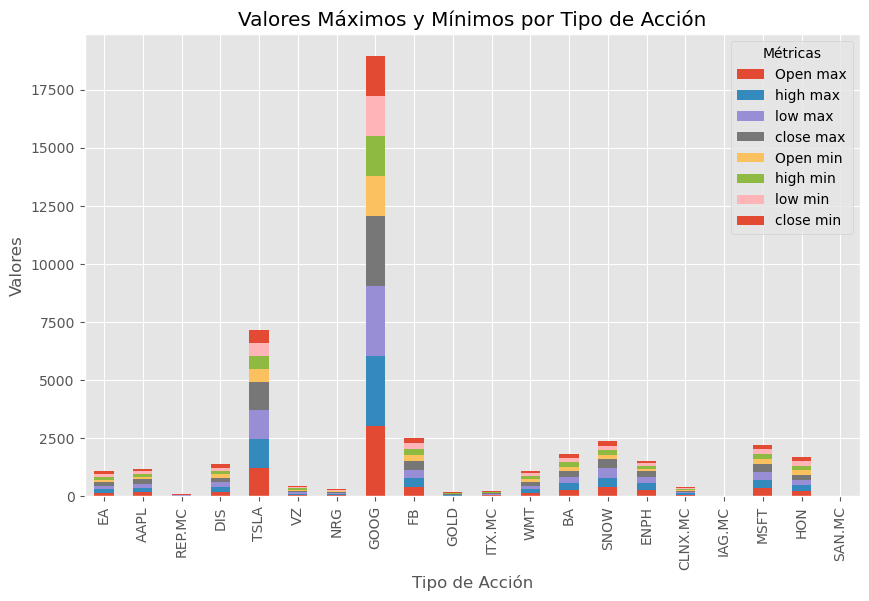

In [12]:
# Convierto el DataFrame de PySpark a DataFrame de Pandas para generar un gráfico
# Omito la columna volume ya que sus valores tan elevandos no permiten realizar una comparación con el resto de columnas
chart_mean = ticker_maxmin.toPandas()

# Tipo del Gráfico
plt.style.use('ggplot')

# Defino las columnas
columns = ['Open max', 'high max', 'low max', 'close max', 'Open min', 'high min', 'low min', 'close min']

# Configuración del gráfico
chart_mean.set_index('ticker')[columns].plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Tipo de Acción')
plt.ylabel('Valores')
plt.title('Valores Máximos y Mínimos por Tipo de Acción')
plt.legend(title='Métricas')
plt.show()